# MNIST digit recognition from scratch using numpy

* Idea from [this great video](https://www.youtube.com/watch?v=w8yWXqWQYmU)
* 3 Layers neural network:
    1. Input layer: 784 nodes, one for each pixel of 28x28 images
    2. Hidden layer: 10 nodes, [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function
    3. Output layer: 10 nodes, one for each digit from 0 to 9, [Softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function


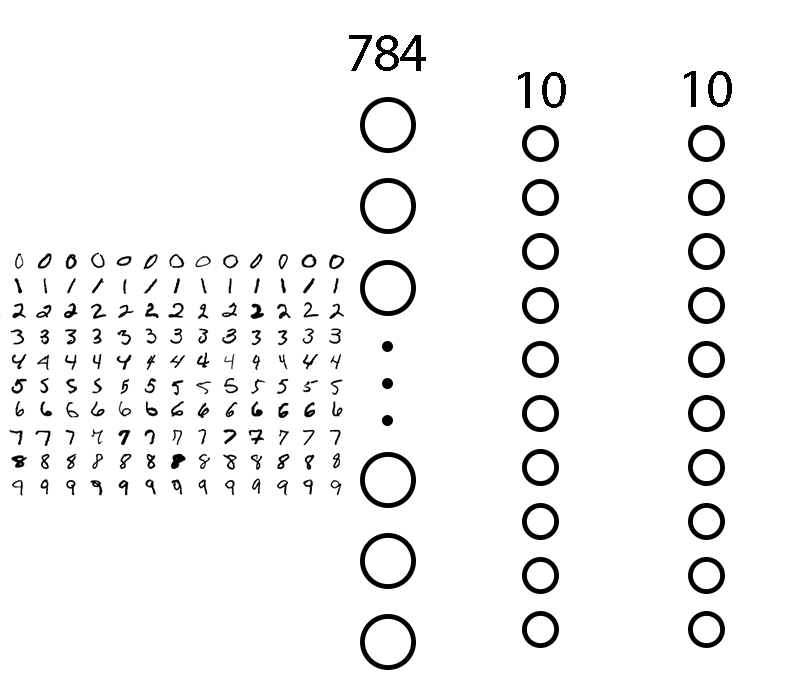

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as keras
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
data_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

def data_splitter(data: np.ndarray):
    train_prop = .2
    train_len = int(train_prop * data.shape[0])
    
    np.random.shuffle(data)
    return data[:train_len, 1:].T, data[train_len:, 1:].T, data[:train_len, 0].T, data[train_len:, 0].T

array = data_train.to_numpy()

X_train, X_test, Y_train, Y_test = data_splitter(np.c_[array[:, 0], array[:, 1:] / 255])
print(X_train.shape, X_test.shape)
print(Y_train, Y_train.shape)

(784, 8400) (784, 33600)
[3. 0. 2. ... 9. 0. 5.] (8400,)


In [3]:
# rough equivalent of our model done in keras for comparison
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='relu', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))

Y_train_hot = tf.one_hot(Y_train, 10)
Y_test_hot = tf.one_hot(Y_test, 10)

model.compile('adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.fit(X_train.T, Y_train_hot, epochs=10)
model.evaluate(X_test.T, Y_test_hot)

2022-07-17 16:59:08.621062: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-17 16:59:08.959870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
263/263 [==============================] - 1s 2ms/step - loss: 1.2078 - accuracy: 0.6611
Epoch 2/10
263/263 [==============================] - 0s 2ms/step - loss: 0.5112 - accuracy: 0.8658
Epoch 3/10
263/263 [==============================] - 0s 1ms/step - loss: 0.3904 - accuracy: 0.8900
Epoch 4/10
263/263 [==============================] - 0s 2ms/step - loss: 0.3400 - accuracy: 0.9044
Epoch 5/10
263/263 [==============================] - 0s 1ms/step - loss: 0.3086 - accuracy: 0.9137
Epoch 6/10
263/263 [==============================] - 0s 1ms/step - loss: 0.2852 - accuracy: 0.9194
Epoch 7/10
263/263 [==============================] - 0s 2ms/step - loss: 0.2697 - accuracy: 0.9240
Epoch 8/10
263/263 [==============================] - 0s 2ms/step - loss: 0.2561 - accuracy: 0.9288
Epoch 9/10
263/263 [==============================] - 0s 2ms/step - loss: 0.2444 - accuracy: 0.9310
Epoch 10/10
1050/1050 [==============================] - 1s 1ms/step - loss: 0.3255 - accuracy: 0.90

[0.32549551129341125, 0.9055059552192688]

In [4]:
def relu(x: np.ndarray):
    return np.maximum(0, x)

def softmax(x: np.ndarray):
    e = np.exp(x)
    return e / sum(e)

def deriv_relu(x: np.ndarray):
    return x > 0

def forward_prop(w1: np.ndarray, w2: np.ndarray, b1: np.ndarray, b2: np.ndarray, X: np.ndarray):
    l1 = np.matmul(w1, X) + b1
    l1_output = relu(l1)
    l2 = np.matmul(w2, l1_output) + b2
    l2_output = softmax(l2)
    return l1, l1_output, l2, l2_output

def normalize_Y(Y: np.ndarray):
    Y_norm = np.zeros((Y_train.shape[0], 10))
    Y_norm[np.arange(Y_train.shape[0], dtype=int), Y_train.astype(int)] = 1
    return Y_norm.T

def back_prop(y: np.ndarray, w2: np.ndarray, l1: np.ndarray, l2: np.ndarray, l1_out: np.ndarray, l2_out: np.ndarray, x: np.ndarray):
    m = y.shape[0]
    Y_norm = normalize_Y(y)
    
    dl2 = l2_out - Y_norm
    dw2 = 1 / m * np.matmul(dl2, l1_out.T)
    db2 = 1 / m * np.sum(dl2)
    dl1 = w2.T.dot(dl2) * deriv_relu(l1)
    dw1 = 1 / m * np.matmul(dl1, x.T)
    db1 = 1 / m * np.sum(dl1)
    
    return dw1, dw2, db1, db2
    
def update_params(w1, w2, b1, b2, dw1, dw2, db1, db2, rate):
    w1 = w1 - rate * dw1
    w2 = w2 - rate * dw2
    b1 = b1 - rate * db1
    b2 = b2 - rate * db2
    return w1, w2, b1, b2


In [5]:
def init_params():
    b1 = np.random.rand(10, 1) - .5
    b2 = np.random.rand(10, 1) - .5
    w1 = np.random.rand(10, 784) - .5
    w2 = np.random.rand(10, 10) - .5
    return w1, w2, b1, b2

In [6]:
def fit(X, Y, rate, iterations, verbose=False):
    w1, w2, b1, b2 = init_params()

    for i in range(int(iterations)):
        l1, l1_out, l2, l2_out = forward_prop(w1, w2, b1, b2, X)
        dw1, dw2, db1, db2 = back_prop(Y, w2, l1, l2, l1_out, l2_out, X)
        w1, w2, b1, b2 = update_params(w1, w2, b1, b2, dw1, dw2, db1, db2, rate)
        if verbose and i % 25 == 0:
            print((Y == np.argmax(l2_out, axis=0)).sum() / Y.size)
    print(f'End of training: {(Y == np.argmax(l2_out, axis=0)).sum() / Y.size} accuracy')
    return w1, w2, b1, b2

In [7]:
iterations = 500
w1, w2, b1, b2 = fit(X_train, Y_train, .1, iterations, verbose=True)
# Test set:
_, _, _, y_hat = forward_prop(w1, w2, b1, b2, X_test)
print(f'Test set: {(Y_test == np.argmax(y_hat, axis=0)).sum()} accurate results on a {Y_test.size} images set ({(Y_test == np.argmax(y_hat, axis=0)).sum() / Y_test.size * 100:.2f}%) after {iterations} iterations')
print(f'w1:\n{w1}\n\nw2:\n{w2}\n\nb1:\n{b1}\n\nb2:\n{b2}')

0.07392857142857143
0.23964285714285713
0.3188095238095238
0.37666666666666665
0.43535714285714283
0.5622619047619047
0.6760714285714285
0.7314285714285714
0.7586904761904761
0.7777380952380952
0.7902380952380952
0.8
0.8107142857142857
0.8203571428571429
0.8280952380952381
0.8355952380952381
0.8407142857142857
0.8459523809523809
0.8504761904761905
0.8536904761904762
End of training: 0.8567857142857143 accuracy
Test set: 28123 accurate results on a 33600 images set (83.70%) after 500 iterations
w1:
[[-3.04571015e-01  3.20721279e-01 -1.15351998e-01 ... -2.77136941e-03
  -2.94223961e-01 -3.91936116e-01]
 [ 1.06607440e-01  1.16778220e-01  1.04885761e-01 ... -1.75515759e-01
   2.80385120e-01  4.48229879e-02]
 [ 2.30066399e-01  3.40155632e-01 -3.42888818e-01 ...  1.02330375e-01
  -3.74110815e-01  1.07544709e-01]
 ...
 [ 2.54237539e-01 -1.04839944e-01 -8.09536713e-02 ...  5.77598837e-02
   1.53442701e-01  1.58618672e-01]
 [ 1.00061028e-01  3.27110887e-02  2.74690581e-01 ...  3.15885919e-01
  